# A/B Testing and Power Analysis



We going to A/B test the new landing page of a webside. I got data from https://www.kaggle.com/datasets/zhangluyuan/ab-testing.

The test metric is Conversion Rate (CR):
$$
    CR = converted / (converted + notconverted)
$$

Hypothesis: Changing landing page will increase the CR of the web.


In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

In [2]:
data = pd.read_csv("../data/ab_data.csv", parse_dates=["timestamp"])

In [3]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
data.shape

(294478, 5)

In [5]:
multipletime_user = data["user_id"].value_counts()[data["user_id"].value_counts() > 1].index
data = data[~data["user_id"].isin(multipletime_user)]

In [6]:
data.shape

(286690, 5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       286690 non-null  int64         
 1   timestamp     286690 non-null  datetime64[ns]
 2   group         286690 non-null  object        
 3   landing_page  286690 non-null  object        
 4   converted     286690 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.1+ MB


In [8]:
data["group"].value_counts()

treatment    143397
control      143293
Name: group, dtype: int64

In [18]:
# the control group see old_page and the treatment group see the new_page
pd.crosstab(data['group'], data['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


## Designing the A/B test in 4 steps
1. setup statistical hypothesis
2. find the minimum (reliably) detectable effect or MDE size & determine the test durartion 
3. calculate the appropriate sample size

### 1. Setup Statistical Hypothesis
$$
    H_0 : \mu_c = \mu_t \\
    H_1 : \mu_c \neq \mu_t
$$

$\mu_c$ is sampling distribution mean of CR in control group  
$\mu_t$  is sampling distribution mean of CR in treatment group  

### 2. find the minimum (reliably) detectable effect or MDE size & determine the test durartion 
The MDE affects the appropriate sample size for running an A/B test. The lower MDE, the larger sample size are required to correctly reject the Null Hypothesis at an certain probability. Too large MDE can leads to wasted test. For example, we set MDE at 50% of increasing conversion rate. In this case, it's like we running an unlogical test and the test unlikely to deriver any significant result, and of couse we wasted our time and money. In contrast, we set too low MDE. The test will required more sample size to correctly reject the Null Hypothesis at an certain probability. This means that we have to run our test longer and spend more money and time. The appropriate MDE should be set in the businessman sight. Basically, it shoud be the smallest effect that make your business breakeven if you implement the change that is being tested. 

In this notebook, let's say we are runing the test within a week.

In [9]:
old_data = data[(data["timestamp"] >= "2017-01-02") & 
               (data["timestamp"] < "2017-01-10") &
               (data["group"] == "control")] # assume it the info before new landning page

A_data = data[(data["timestamp"] >= "2017-01-10") & 
               (data["timestamp"] < "2017-01-18") &
               (data["group"] == "control")] # running the test in next week 

B_data = data[(data["timestamp"] >= "2017-01-10") & 
               (data["timestamp"] < "2017-01-18") &
               (data["group"] == "treatment")] # running the test in next week 

In [10]:
cr_old = old_data["converted"].sum() / old_data["converted"].shape[0]
print(cr_old)

0.11920694441567051


In [31]:
# set various MDE 
MDE_small = 0.01 # 1%
MDE_medium = 0.10 # 10%
MDE_large = 0.20 # 20%

In [32]:
cr_old * (1 + MDE_small)

0.12039901385982721

In [33]:
cr_old * (1 + MDE_medium)

0.13112763885723758

In [34]:
cr_old * (1 + MDE_large)

0.1430483332988046

Let's say the business would like to see an increase in CR of at least 10% in order to implement the new landing page. So, we pick MDE at 0.1

### 3. calculate the appropriate sample size
This could be done using a Power Analysis. The appropriate sample size depends on 
- MDE as mention above
- alpha, the significance level, e.g. 0.05, is the probability of a type I error, that is wrong rejections if the Null Hypothesis is true
- power, the power of the test, e.g. 0.8, is one minus the probability of a type II error. Power is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true

We will deep down into the details of Power Analysis later, but now we will use NormalIndPower.solve_power function from statsmodels.stats.api to easily solve the appropriate sample size.

In [35]:
import statsmodels.stats.api as sms
effect_size = sms.proportion_effectsize(cr_old, cr_old * (1 + MDE_medium))

required_n = sms.NormalIndPower().solve_power(
    effect_size=effect_size,
    power=0.8, # we would like to correctly reject the H0 with 80% probability
    alpha=0.05, # we ok with 5% of type I error
)

print(required_n)

12089.86383585548


In real work this means we have to run the test until we got 12090 samples of each group. So, I will just random pick the 12090 from A and B

In [49]:
control_data = A_data.reset_index(drop=True).sample(round(required_n), random_state=42)


In [50]:
treatment_data = B_data.reset_index(drop=True).sample(round(required_n), random_state=42)

## Run A/B Testing

In [55]:
import scipy.stats as stats
se = lambda x: stats.sem(x, ddof=0)

ab_data = pd.concat([control_data, treatment_data], axis=0)
converted = ab_data.groupby("group")["converted"].agg(["count", np.sum, np.mean, np.std, se])
converted.columns = ["nobs", "total_converted", "conversion_rate", "standard_deviation", "standard_error"]
converted

,nobs,total_converted,conversion_rate,standard_deviation,standard_error
group,,,,,
control,12090,1385,0.114557,0.318500,0.002897
treatment,12090,1433,0.118528,0.323245,0.002940


In [56]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
successes = [converted["total_converted"]["control"], converted["total_converted"]["treatment"]]
nobs = [converted["nobs"]["control"], converted["nobs"]["treatment"]]

z_stat, pval = proportions_ztest(successes, nobs=nobs)

print(f"z-stat is {z_stat}, p-value is {pval}")

z-stat is -0.9620063436938238, p-value is 0.3360464173664066


The p-value of 0.336 suggests that we can not reject H0. Although we found a little bit higher of conversion rate of treatment group but it is no significantly different from the control group.  

In [57]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f"confidence interval of control group is [{lower_con}, {upper_con}]")
print(f"confidence interval of treatment group is [{lower_treat}, {upper_treat}]")

confidence interval of control group is [0.10888038136811548, 0.12023458968233944]
confidence interval of treatment group is [0.11276602774067992, 0.12428938995989908]


In [58]:
converted

,nobs,total_converted,conversion_rate,standard_deviation,standard_error
group,,,,,
control,12090,1385,0.114557,0.318500,0.002897
treatment,12090,1433,0.118528,0.323245,0.002940


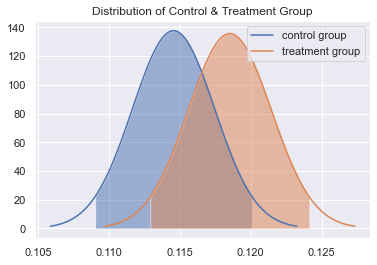

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

mu_c = converted["conversion_rate"]["control"]
sigma_c = converted["standard_error"]["control"]
x = np.linspace(mu_c - 3*sigma_c, mu_c + 3*sigma_c, 100)
pdf_c = stats.norm.pdf(x, mu_c, sigma_c)
plt.plot(x, pdf_c, label="control group")
plt.fill_between(x, pdf_c, where=(lower_con < x) & (x < upper_con), alpha=0.5)

mu_t = converted["conversion_rate"]["treatment"]
sigma_t = converted["standard_error"]["treatment"]
x = np.linspace(mu_t - 3*sigma_t, mu_t + 3*sigma_t, 100)
pdf_t = stats.norm.pdf(x, mu_t, sigma_t)
plt.plot(x, pdf_t, label="treatment group")
plt.fill_between(x, pdf_t, where=(lower_treat < x) & (x < upper_treat), alpha=0.5)

plt.title('Distribution of Control & Treatment Group')
plt.legend()
plt.show()